# Graph Neural Networks: Introduction

# What is GNN?

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS. This notebook is compiled from notes, examples and the source code provided in the [github](https://github.com/deepmind/graph_nets) repository. 





## Getting the libraries ready...

[Graph Nets](https://arxiv.org/abs/1806.01261) is DeepMind's library for building graph networks in Tensorflow and Sonnet. We are familiar with TF but have not used Sonnet in the lecture yet. Sonnet is DeepMind’s library for Neural Networks on top of TensorFlow:

https://github.com/deepmind/sonnet

https://www.youtube.com/watch?v=rlpQjnUvoKw

Here you can find the documentation and further examples.  It is used to construct neural networks for many different purposes in a fast and simple manner. Now lets get the libraries:



In [1]:
# Installing GraphNets...
print("Installing Graph Nets library and dependencies:")
print("Output message from command:\n")
!pip install "graph_nets>=1.1" "dm-sonnet>=2.0.0b0" "tensorflow_probability"
#!pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"

Installing Graph Nets library and dependencies:
Output message from command:

     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 256kB 4.7MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-cp37-none-any.whl size=91856 sha256=a2bd244e74eb20835e9b84a37478b6cc3abbef44f2660d0bec6e7276ad1564f3
  Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets


In [2]:
#--------------------------------------------------------------------------------------------------------------
# Important note:
# If you are running this notebook locally (i.e., not through Colaboratory), 
# you will also need to install a few more dependencies. Run the following on the command line 
# to install the graph networks library, as well as a few other dependencies:
#
#pip install "graph_nets>=1.1" "tensorflow>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability
#--------------------------------------------------------------------------------------------------------------

In [3]:
# Loading libraries:
#
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#
import numpy as np

import collections
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import spatial

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


In [4]:
#
#ML libraries
%tensorflow_version 2.x 
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models


import matplotlib.pyplot as plt
import networkx as nx
import sonnet as snt
import tensorflow as tf

# Learning how to build a graph

## How graphical data is represented: [`graphs.GraphsTuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-graphsgraphstuple) class

The Graph Nets library contains models which operate on graph-structured data: graph goes in; graph goes out. The very first thing to check is how graph-structured data is represented in the code. This is also something you should look into if you are using another library. 

In our case, `graph_nets.graphs.GraphsTuple` class, defined in [`graph_nets/graphs.py`](https://github.com/deepmind/graph_nets/blob/master/graph_nets/graphs.py), represents a **batches of one or more graphs**. All graph network modules take instances of `GraphsTuple` as input, and return instances of `GraphsTuple` as output. The graphs are *directed* (one-way edges), *attributed* (node-, edge-, and graph-level features are allowed), *multigraphs* (multiple edges can connect any two nodes, and self-edges are allowed). You may check the [original paper](https://arxiv.org/pdf/1806.01261.pdf)  for more information.


The main purpose of the `GraphsTuple` is to represent multiple graphs with different shapes and sizes in a way that supports batched processing (this was not an issue before). This module first defines the string constants which are used to represent
graph(s) as tuples or dictionaries: 

+ N_NODE, 
+ N_EDGE, 
+ NODES, 
+ EDGES, 
+ RECEIVERS,
+ SENDERS, 
+ GLOBALS`.

This representation could typically take the following form, for a batch of `n_graphs` graphs stored in a `GraphsTuple` called graph:

- `n_node` (shape=[num_graphs]): Number of nodes in each graph in the batch.
- `n_edge` (shape=[num_graphs]): Number of edges in each graph in the batch.
- `globals` (shape=[num_graphs] + global_feature_dimensions): Global features for each graph in the batch.
- `nodes` (shape=[total_num_nodes] + node_feature_dimensions): Node features for each node in the batch of graphs.
- `edges` (shape=[total_num_edges] + edge_feature_dimensions): Edge features for each edge in the batch of graphs.
- `senders`(shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the source node of each directed edge in `edges`.
- `receivers` (shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the destination node of each directed edge in `edges`.

The nodes and edges from the different graphs in the batch are concatenated along the first axis of the `nodes` and `edges` fields, and can be partitioned using the `n_node` and `n_edge` fields respectively.  Note, all but the "`n_*`" fields are optional.

The attributes of a `GraphsTuple` instance are typically either **Numpy arrays** or **TensorFlow tensors**. The library contains utilities for manipulating graphs with each of these types of attributes, respectively:
  * `utils_np` (for Numpy arrays)
  * `utils_tf` (for TensorFlow tensors)

The `utils_np` and `utils_tf` modules provide convenience methods to work with graph that contain numpy and tensorflow data,respectively: conversion, batching, unbatching, indexing, among others.

An important method of the `GraphsTuple` class is [`GraphsTuple.replace`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#graphsgraphstuplereplacekwargs): Similarly to `collections.namedtuple._replace` (in fact, `GraphsTuple` is sub-class of `collections.namedtuple`), this method creates a copy of the `GraphsTuple`, with references to all of the original attributes, by replacing some of them by the values provided as keyword arguments.


For a holistic view: https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md

## What information is stored on a graph?

Each graph will have a global feature, several nodes, and several edges. The graphs can have different numbers of nodes and edges, but the **lengths** of the global, node, and edge attribute vectors must be the same across graphs.

In order to create a `graphs.GraphsTuple` instance, we can define a `list` whose elements are `dict`s, with the following keys, that contain each graph's data:

+ "globals": Each graph has a single `float`-valued feature vector.
+ "nodes": Each graph has a set of nodes with `float`-valued feature vectors.
+ "edges": Each graph has a set of edges with `float`-valued feature vectors.
+ "senders": Each edge connects a sender node, represented by an `int`-valued node index, to a receiver node.
+ "receivers": Each edge connects a sender node to a receiver node, represented by an `int`-valued node index.

Let's try to create a graph to fully understand what it means:

In [5]:
# Since there may be multiple graphs, lets label them with intigers starting from zero.
# For our first graph, we will have graph "0". By following the above order, lets assign dummy numbers
# to create the graph representation of our data:
#-------------------------------
# Global features for graph 0:
globals_0 = [1.1, 2.2, 3.3]
#
#Defining the node features. These could refer to a flow field variables:
#--------------------------------
# Node features for graph 0:
nodes_0 = [[10., 20., 30.],  # Node 0
           [11., 21., 31.],  # Node 1
           [12., 22., 32.],  # Node 2
           [13., 23., 33.],  # Node 3
           [14., 24., 34.],  # Node 4
           [15., 25., 35.]]  # Node 5
#
#Defining the edge features. These could refer to some special connections between the nodes:
#--------------------------------
# Edge features for graph 0:
edges_0 = [[100., 200.],  # Edge 0
           [101., 201.],  # Edge 1
           [102., 202.],  # Edge 2
           [103., 203.],  # Edge 3
           [104., 204.],  # Edge 4
           [105., 205.],  # Edge 5
           [106., 206.],  # Edge 6
           [107., 207.]]  # Edge 7
#
#Now we need to describe how the edges are placed between the nodes.
#Here we eplicitly define the indices of the sending nodes and the receiver nodes.
#--------------------------------
# The sender and receiver nodes associated with each edge for graph 0.
senders_0 = [0,  # Index of the sender node for edge 0
             1,  # Index of the sender node for edge 1
             5,  # Index of the sender node for edge 2
             2,  # Index of the sender node for edge 3
             4,  # Index of the sender node for edge 4
             7,  # Index of the sender node for edge 5
             3,  # Index of the sender node for edge 6
             6]  # Index of the sender node for edge 7

receivers_0 = [1,  # Index of the receiver node for edge 0
               7,  # Index of the receiver node for edge 1
               6,  # Index of the receiver node for edge 2
               0,  # Index of the receiver node for edge 3
               3,  # Index of the receiver node for edge 4
               5,  # Index of the receiver node for edge 5
               2,  # Index of the receiver node for edge 6
               4]  # Index of the receiver node for edge 7

#--------------------------------
#--------------------------------
# Moving on to the second graph:
#--------------------------------
#--------------------------------
# Global features for graph 1.
globals_1 = [1001., 1002., 1003.]

# Node features for graph 1.
nodes_1 = [[1010., 1020., 1030.],  # Node 0
           [1011., 1021., 1031.]]  # Node 1

# Edge features for graph 1.
edges_1 = [[1100., 1200.],  # Edge 0
           [1101., 1201.],  # Edge 1
           [1102., 1202.],  # Edge 2
           [1103., 1203.]]  # Edge 3

# The sender and receiver nodes associated with each edge for graph 1.
senders_1 = [0,  # Index of the sender node for edge 0
             0,  # Index of the sender node for edge 1
             1,  # Index of the sender node for edge 2
             1]  # Index of the sender node for edge 3
receivers_1 = [0,  # Index of the receiver node for edge 0
               1,  # Index of the receiver node for edge 1
               0,  # Index of the receiver node for edge 2
               0]  # Index of the receiver node for edge 3

#--------------------------------
#--------------------------------
#Creating dictionaries:
#--------------------------------
data_dict_0 = {
    "globals": globals_0,
    "nodes": nodes_0,
    "edges": edges_0,
    "senders": senders_0,
    "receivers": receivers_0
}

data_dict_1 = {
    "globals": globals_1,
    "nodes": nodes_1,
    "edges": edges_1,
    "senders": senders_1,
    "receivers": receivers_1
}

## From list of dictionaries to `GraphsTuple`


The `utils_np` module contains a functions named [`utils_np.data_dicts_to_graphs_tuple`](https://github.com/deepmind/graph_nets/blob/master/graph_nets/utils_np.py?l=381). Its job consists of three steps:

1. It concatenates the data from the multiple graphs together along their innermost axes (i.e. the batch dimension). This allows the graph net to process the node and edge attributes by a shared function in parallel.

2. It counts up the numbers of nodes and edges per graph, and stores them in the fields "n_node" and "n_edge", respectively, where their lengths equal the number of graphs. This is used for keeping track of which nodes and edges belong to which graph, so they can be split up later, and so the graph can broadcast a graph's global attributes across its nodes and edges.

3. It adds an integer offset to the sender and receiver indices, which corresponds to the number of nodes in the preceding graphs. This allows the indices to correspond to the nodes and edges of their corresponding graph, after the node and edge attributes have been concatenated.

Lets use it on our toy example:

In [6]:
# Creating a list of graph dictionaries:
data_dict_list = [data_dict_0, data_dict_1]
# convert lists of data dictionaries to `graphs.GraphsTuple`
graphs_tuple = utils_np.data_dicts_to_graphs_tuple(data_dict_list)

## Lets see the graph we created

It is also easy to get a visual feedback. `GraphsTuple` objects can be converted into a `list` of `networkx` objects for easy visualization. Lets try it:

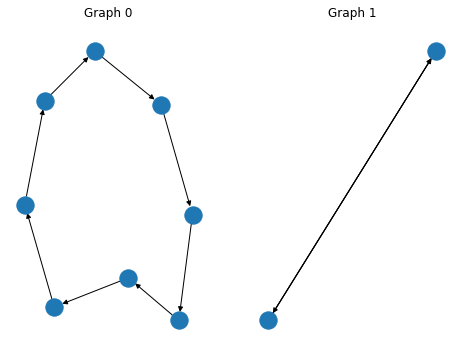

In [7]:
# The link:
#https://github.com/deepmind/graph_nets/blob/master/graph_nets/utils_np.py?l=366
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
#Plotting the graphs:
_, axs = plt.subplots(ncols=2, figsize=(8, 6))
for iax, (graph_nx, ax) in enumerate(zip(graphs_nx, axs)):
  nx.draw(graph_nx, ax=ax)
  ax.set_title("Graph {}".format(iax))

We can also print out the information about the data stored on a GraphsTuple:

In [8]:
def print_graphs_tuple(graphs_tuple):
  print("Shapes of GraphsTuple's fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=graphs.ALL_FIELDS))
  print("\nData contained in GraphsTuple's fields:")
  print(f"globals:\n{graphs_tuple.globals}")
  print(f"nodes:\n{graphs_tuple.nodes}")
  print(f"edges:\n{graphs_tuple.edges}")
  print(f"senders:\n{graphs_tuple.senders}")
  print(f"receivers:\n{graphs_tuple.receivers}")
  print(f"n_node:\n{graphs_tuple.n_node}")
  print(f"n_edge:\n{graphs_tuple.n_edge}")

print_graphs_tuple(graphs_tuple)

Shapes of GraphsTuple's fields:
GraphsTuple(nodes=(8, 3), edges=(12, 2), receivers=(12,), senders=(12,), globals=(2, 3), n_node=(2,), n_edge=(2,))

Data contained in GraphsTuple's fields:
globals:
[[   1.1    2.2    3.3]
 [1001.  1002.  1003. ]]
nodes:
[[  10.   20.   30.]
 [  11.   21.   31.]
 [  12.   22.   32.]
 [  13.   23.   33.]
 [  14.   24.   34.]
 [  15.   25.   35.]
 [1010. 1020. 1030.]
 [1011. 1021. 1031.]]
edges:
[[ 100.  200.]
 [ 101.  201.]
 [ 102.  202.]
 [ 103.  203.]
 [ 104.  204.]
 [ 105.  205.]
 [ 106.  206.]
 [ 107.  207.]
 [1100. 1200.]
 [1101. 1201.]
 [1102. 1202.]
 [1103. 1203.]]
senders:
[0 1 5 2 4 7 3 6 6 6 7 7]
receivers:
[1 7 6 0 3 5 2 4 6 7 6 6]
n_node:
[6 2]
n_edge:
[8 4]


## Data conversion: back to dict

We also have the reverse tool: it is  possible to retrieve a `list` of  graph `dict`s by using `utils_np.graphs_tuple_to_data_dicts`:

In [9]:
recovered_data_dict_list = utils_np.graphs_tuple_to_data_dicts(graphs_tuple)
print (recovered_data_dict_list[1])

{'nodes': array([[1010., 1020., 1030.],
       [1011., 1021., 1031.]]), 'edges': array([[1100., 1200.],
       [1101., 1201.],
       [1102., 1202.],
       [1103., 1203.]]), 'receivers': array([0, 1, 0, 0]), 'senders': array([0, 0, 1, 1]), 'globals': array([1001., 1002., 1003.]), 'n_node': 2, 'n_edge': 4}


## Other examples

### Graph with no feature (connectivity information)

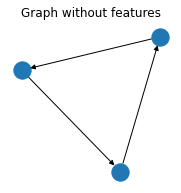

In [10]:
n_node = 3
# Three edges connecting the nodes in a cycle
senders = [0, 1, 2]  # Indices of nodes sending the edges
receivers = [1, 2, 0]  # Indices of nodes receiving the edges

data_dict = {
    "n_node": n_node,
    "senders": senders,
    "receivers": receivers,
}
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
# We can visualize the graph using networkx.
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
_ = ax.set_title("Graph without features")

### Graph without edges

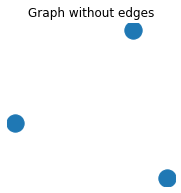

In [11]:
# Node features:
nodes = [[10.],  # Node 0
         [11.],  # Node 1
         [12.]]  # Node 2
data_dict = {
    "nodes": nodes,
}
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
# We can visualize the graph using networkx.
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
_ = ax.set_title("Graph without edges")

### GraphsTuple from a `networkx` graph

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks:

https://networkx.org/

A GraphsTuple to be built from networkx graphs as follows:


In [12]:
# This is similar to how we built MLP with TF:
#Create object:
graph_nx = nx.OrderedMultiDiGraph()
# Globals:
graph_nx.graph["features"] = np.array([0.6, 0.7, 0.8])
# Nodes:
graph_nx.add_node(0, features=np.array([0.3, 1.3]))
graph_nx.add_node(1, features=np.array([0.4, 1.4]))
graph_nx.add_node(2, features=np.array([0.5, 1.5]))
graph_nx.add_node(3, features=np.array([0.6, 1.6]))
# Edges: Note that sends and receivers are defined here:
graph_nx.add_edge(0, 1, features=np.array([3.6, 3.7]))
graph_nx.add_edge(2, 0, features=np.array([5.6, 5.7]))
graph_nx.add_edge(3, 0, features=np.array([6.6, 6.7]))
# See the result:
graphs_tuple = utils_np.networkxs_to_graphs_tuple([graph_nx])
print_graphs_tuple(graphs_tuple)


Shapes of GraphsTuple's fields:
GraphsTuple(nodes=(4, 2), edges=(3, 2), receivers=(3,), senders=(3,), globals=(1, 3), n_node=(1,), n_edge=(1,))

Data contained in GraphsTuple's fields:
globals:
[[0.6 0.7 0.8]]
nodes:
[[0.3 1.3]
 [0.4 1.4]
 [0.5 1.5]
 [0.6 1.6]]
edges:
[[3.6 3.7]
 [5.6 5.7]
 [6.6 6.7]]
senders:
[0 2 3]
receivers:
[1 0 0]
n_node:
[4]
n_edge:
[3]


Text(0.5, 1.0, 'Graph')

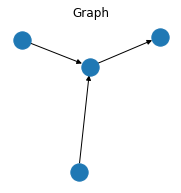

In [13]:
# Plotting:
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graph_nx, ax=ax)
ax.set_title("Graph")

### Creating a constant tensor `GraphsTuple` from data dicts

Similar to `utils_np.data_dicts_to_graphs_tuple`,  the `utils_tf` module, contains a function named `utils_tf.data_dicts_to_graphs_tuple`, which creates a constant tensor graph from data dicts, containing either numpy arrays of TF tensors.

In [14]:
# Lets automate the boring staff:
#--------------------------------
# size definitions:
GLOBAL_SIZE = 4
NODE_SIZE = 5
EDGE_SIZE = 6
# graph data generator:
def get_graph_data_dict(num_nodes, num_edges):
  return {
      "globals": np.random.rand(GLOBAL_SIZE).astype(np.float32),
      "nodes": np.random.rand(num_nodes, NODE_SIZE).astype(np.float32),
      "edges": np.random.rand(num_edges, EDGE_SIZE).astype(np.float32),
      "senders": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
      "receivers": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
  }

# Calling the function:
graph_2_nodes_3_edges = get_graph_data_dict(num_nodes=2, num_edges=3)
graph_3_nodes_5_edges = get_graph_data_dict(num_nodes=3, num_edges=5)
graph_5_nodes_8_edges = get_graph_data_dict(num_nodes=5, num_edges=8)
graph_8_nodes_13_edges = get_graph_data_dict(num_nodes=8, num_edges=13)

graph_dicts = [graph_2_nodes_3_edges, graph_3_nodes_5_edges,
               graph_5_nodes_8_edges, graph_8_nodes_13_edges]

# Plot generator I:
def plot_graphs_tuple(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)

# Plot generator II:
def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)
  #Makeup...
  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)
  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)
  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)
  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos
# Graph comparison:
def plot_compare_graphs(graphs_tuples, labels):
  pos = None
  num_graphs = len(graphs_tuples)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  pos = None
  for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
    graph = utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]
    pos = plot_graph_networkx(graph, ax, pos=pos)
    ax.set_title(name)

Lets use the `utils_tf.data_dicts_to_graphs_tuple` on the generated list above:

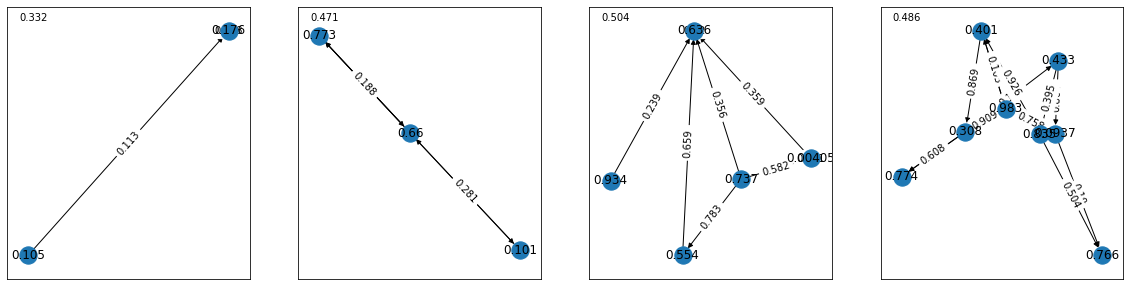

In [15]:
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
# Using the plot function above:
plot_graphs_tuple(graphs_tuple_tf)

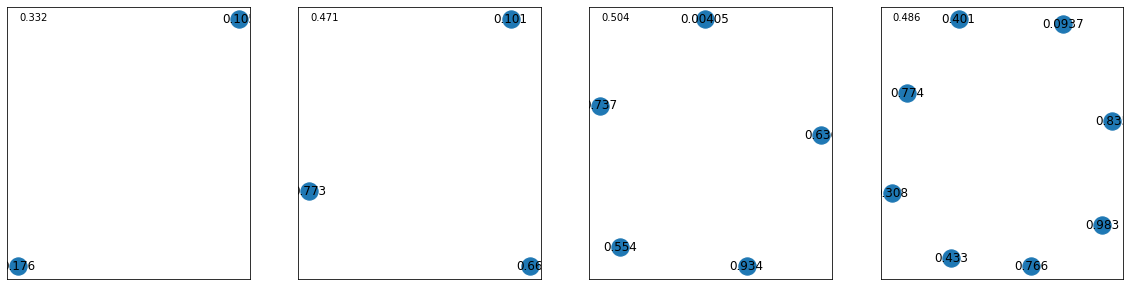

In [16]:
# Removing the edges from a graph.
graph_with_nones = graphs_tuple_tf.replace(
    edges=None, senders=None, receivers=None, n_edge=graphs_tuple_tf.n_edge*0)

plot_graphs_tuple(graph_with_nones)

### Filtering a subset of graphs

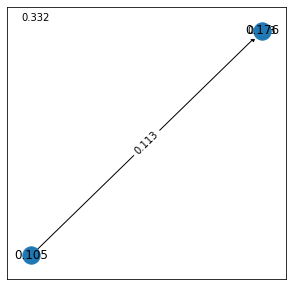

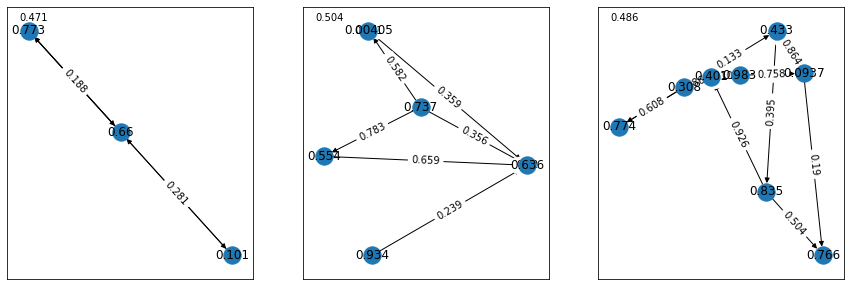

In [17]:
# If the GraphsTuple has None's we need to make use of `utils_tf.make_runnable_in_session`.
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

first_graph_tf = utils_tf.get_graph(graphs_tuple_tf, 0)
three_graphs_tf = utils_tf.get_graph(graphs_tuple_tf, slice(1, 4))

plot_graphs_tuple(first_graph_tf)
plot_graphs_tuple(three_graphs_tf)

### Concatenating multiple GraphsTuple instances

You can concatenate mutiple GraphsTuple instances along a given dimension:

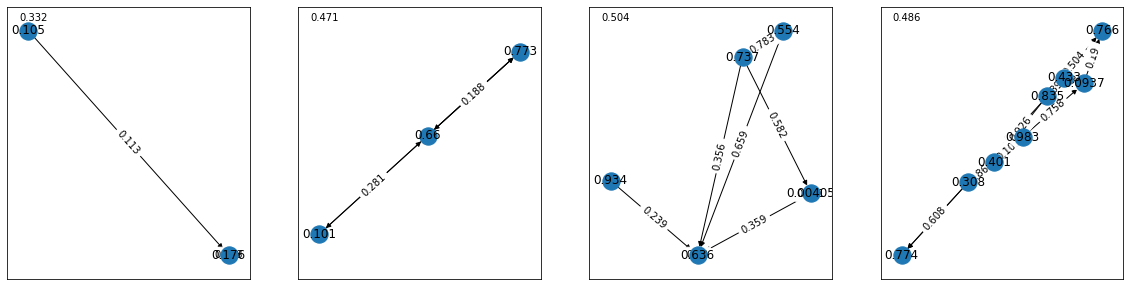

In [18]:
# Concatenating along the batch dimension
graphs_tuple_1_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts[0:1])
graphs_tuple_2_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts[1:])

graphs_tuple_tf = utils_tf.concat([graphs_tuple_1_tf, graphs_tuple_2_tf], axis=0)

plot_graphs_tuple(graphs_tuple_tf)

For more methods and explicit details, see:

https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md

# Graph Net: How to use it

As always mentioned, most of the time for DDE applications goes to data management. The above section is a glimpse of how to manipulate graph-structured data via the `GraphsTuple` class and the `utils_np` and `utils_tf` utilities. Now lets go to the fun staff and see how to use graph networks.

## Initialization of the [GraphNetwork](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesgraphnetwork) module:

![Graph Network block](https://github.com/deepmind/graph_nets/raw/master/images/graph-network.png)

A graph network has up to three learnable sub-functions: edge ($\phi^e$), node ($\phi^v$), and global ($\phi^u$). The schematic above is taken from the code repo and you can check the details from the original work, [Section 3.2.2](https://arxiv.org/pdf/1806.01261.pdf).

To intiate a graph network module, these sub-functions are specified via constructor arguments which are `callable`s that return Sonnet modules: e.g., `snt.Linear`,`snt.nets.MLP` etc.

You can check the arguments from [here](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#args-47).

In [19]:
OUTPUT_EDGE_SIZE = 10
OUTPUT_NODE_SIZE = 11
OUTPUT_GLOBAL_SIZE = 12

graph_network = modules.GraphNetwork(
    # Passing the arguments:
    #-----------------------
    # edge_model_fn: A callable that will be passed to EdgeBlock to perform per-edge computations.
    edge_model_fn=lambda: snt.Linear(output_size=OUTPUT_EDGE_SIZE),
    # node_model_fn: A callable that will be passed to NodeBlock to perform per-node computations. 
    node_model_fn=lambda: snt.Linear(output_size=OUTPUT_NODE_SIZE),
    # global_model_fn: A callable that will be passed to GlobalBlock to perform per-global computations.
    global_model_fn=lambda: snt.Linear(output_size=OUTPUT_GLOBAL_SIZE)
    )

## Feeding a `GraphsTuple` to a Graph Net

A `GraphsTuple` is to be fed into a graph network, returning an output graph with the same number of nodes, edges, and edge connectivity. The difference is now we get updated edge, node and global features. All of the output features are conditioned on the input features according to the graph structure, and are fully differentiable.

In [20]:
# Define an input graph:
input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
# Calling "graph_network"
output_graphs = graph_network(input_graphs)
# printing shapes
print(f"Output edges size: {output_graphs.edges.shape[-1]}")
print(f"Output nodes size: {output_graphs.nodes.shape[-1]}")  
print(f"Output globals size: {output_graphs.globals.shape[-1]}")  
# (compare the shapes with the given values above)

Output edges size: 10
Output nodes size: 11
Output globals size: 12


### Multiple GN blocks in sequence

A Graph Net module can be recurrently connected by matching the output feature sizes to the input feature sizes, and feeding the output back to the input multiple times:


In [21]:
# Initial graph
input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
# Creating the Graph Net object
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=GLOBAL_SIZE))
# Recurrent loop over the graph:
num_recurrent_passes = 3
previous_graphs = input_graphs
for unused_pass in range(num_recurrent_passes):
  previous_graphs = graph_network(previous_graphs)
#Give the end results:
output_graphs = previous_graphs

## Other Graph Net modules

Other modules discussed [the original work](https://arxiv.org/abs/1806.01261) are already included in `graph_nets.modules`:
- [`modules.GraphIndependent`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesgraphindependent) (updates the global, node, and edge features independently, without message-passing)
- [`modules.InteractionNetwork`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork) (an example of a "Message-passing neural network")
- [`modules.CommNet`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulescommnet) (another example of a "Message-passing neural network")
- [`modules.SelfAttention`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesselfattention) (an example of a "Non-local neural network")
- [`modules.RelationNetwork`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesrelationnetwork)
- [`modules.DeepSets`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesdeepsets)

Visit these descriptions if you need to construct a model for your own problem. It may match your needs. 

## What if I need a special Graph Network?

If you want to build your own custom graph network, you should check the basic building blocks provided in `graph_nets.blocks`.

https://github.com/deepmind/graph_nets/blob/master/graph_nets/blocks.py

You should remember that these blocks will help you to design the flow of information on the graph (hence you should craft an algorithm first). Below you will find official descriptions for various blocks, for future reference. 


### Broadcast operations

Broadcast operations allow to transfer information between different types of elements in the graph:
- [`blocks.broadcast_globals_to_nodes`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_globals_to_nodesgraph-namebroadcast_globals_to_nodes): Copy/broadcast global features across all nodes.
- [`blocks.broadcast_globals_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_globals_to_edgesgraph-namebroadcast_globals_to_edges): Copy/broadcast global features across all edges.
- [`blocks.broadcast_sender_nodes_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_sender_nodes_to_edgesgraph-namebroadcast_sender_nodes_to_edges): Copy/broadcast node information from each node, across all edges for which that node is a sender.
- [`blocks.broadcast_receiver_nodes_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_receiver_nodes_to_edgesgraph-namebroadcast_receiver_nodes_to_edges): Copy/broadcast node information from each node, across all edges for which that node is a receiver.

Broadcasters can be used, for example, to set the value of each edge to be the sum of the first feature element of: the input edges, the sender nodes, the receiver nodes, and the global feature.

### Aggregators

Aggregators perform reduce operations between different elements of the graph:

- [`blocks.EdgesToGlobalsAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksedgestoglobalsaggregator): Aggregates the sets of features for all edges into a single global set of features.
- [`blocks.NodesToGlobalsAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksnodestoglobalsaggregator): Aggregates the sets of features for all nodes into a single global set of features.
- [`blocks.SentEdgesToNodesAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blockssentedgestonodesaggregator): Aggregates the sets of features for all edges sent by each node into a single set of features for that node.
- [`blocks.ReceivedEdgesToNodesAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksreceivededgestonodesaggregator): Aggregates the sets of features for all edges received by each node into a single set of features for that.

Different types of reduce operations are:
- [`tf.unsorted_segment_sum`](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum): Elementwise sum. Set to 0 for empty sets.
- [`tf.unsorted_segment_mean`](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_mean): Elementwise mean. Set to 0 for empty sets.
- [`tf.unsorted_segment_prod`](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_prod): Elementwise prod. Set to 1 for empty sets.
- [`blocks.unsorted_segment_max_or_zero`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksunsorted_segment_max_or_zerovalues-indices-num_groups-nameunsorted_segment_max_or_zero): Elementwise max. Set to 0 for empty sets.
- [`blocks.unsorted_segment_min_or_zero`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksunsorted_segment_max_or_zerovalues-indices-num_groups-nameunsorted_segment_min_or_zero): Elementwise min. Set to 0 for empty sets.


### [`blocks.EdgeBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksedgeblock)

An EdgeBlock consists of applying a function to the concatenation of:
-  `graphs_tuple.edges`
- `blocks.broadcast_sender_nodes_to_edges(graphs_tuple)`
- `blocks.broadcast_receiver_nodes_to_edges(graphs_tuple)`
- `blocks.broadcast_globals_to_edges(graphs_tuple)`

The result is a graph with new edge features conditioned on input edges, nodes and global features according to the graph structure.

### [`blocks.NodeBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksnodeblock)

An NodeBlock consists of applying a function to the concatenation of:
-  `graphs_tuple.nodes`
- `blocks.ReceivedEdgesToNodesAggregator(<reducer-function>)(graphs_tuple)`
- `blocks.broadcast_globals_to_nodes(graphs_tuple)`

The result is a graph with new node features conditioned on input edges, nodes and global features according to the graph structure.

### [`blocks.GlobalBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksglobalblock)

An GlobalBlock consists of applying a function to the concatenation of:

- `graphs_tuple.globals`
- `blocks.EdgesToGlobalsAggregator(<reducer-function>)(graphs_tuple)`
- `blocks.NodesToGlobalsAggregator(<reducer-function>)(graphs_tuple)`

The result is a graph with new globals features conditioned on input edges, nodes and global features.

### Block compositionality

A `modules.GraphNetwork` is composed internally of a `modules.EdgeBlock`,  a `modules.NodeBlock`, and a `modules.GlobalBlock`, connected serially. This allows every field in the output to be conditioned by any field in the input.

Most of the existing neural networks operating on graphs can be built upon this set of building blocks using their different configuration options. See `graph_nets.modules` for some examples.

# Basic Examples from deepMind

Lets go over an example to solidfy our skills on using GNN.

In [ ]:
import os
def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [19]:
# Loading libraries:
#
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#
import numpy as np

import collections
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import spatial

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


In [20]:
#
#ML libraries
%tensorflow_version 1.x 
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models


import matplotlib.pyplot as plt
import networkx as nx
import sonnet as snt
import tensorflow as tf

## Dynamics of a mass-spring system

In this example, our objective is to predict the motion of a set of masses connected by springs.

**Problem definition:** 

The network will be trained to predict the behaviour of a chain of masses, connected by identical springs. The first and last masses are fixed; the others are subject to gravity.

After training, the network's prediction ability will be checked  by comparing its output to the ground truth.  In the next step, we will test how generalizable the network predictions are by using the model on a more complex system. 

In [21]:
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

### Creating the base graph

In [22]:
def base_graph(n, d):
  """Define a basic mass-spring system graph structure.

  These are n masses (1kg) connected by springs in a chain-like structure. The
  first and last masses are fixed. The masses are vertically aligned at the
  start and are d meters apart; this is also the rest length for the springs
  connecting them. Springs have spring constant 50 N/m and gravity is 10 N in
  the negative y-direction.

  Args:
    n: number of masses
    d: distance between masses (as well as springs' rest length)

  Returns:
    data_dict: dictionary with globals, nodes, edges, receivers and senders
        to represent a structure like the ones we created above.
  """

  # 
  #-----------------------------------------------------------------------------
  # Generate initial position and velocity for all masses.
  # The left-most mass has is at position (0, 0); other masses (ordered left to
  # right) have x-coordinate d meters apart from their left neighbor, and
  # y-coordinate 0. All masses have initial velocity 0 m/s.
  #-----------------------------------------------------------------------------
  #Nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each node.
  nodes = np.zeros((n, 5), dtype=np.float32)
  half_width = d * n / 2.0
  nodes[:, 0] = np.linspace(
      -half_width, half_width, num=n, endpoint=False, dtype=np.float32)
  # indicate that the first and last masses are fixed
  nodes[(0, -1), -1] = 1.
  #-----------------------------------------------------------------------------
  # Edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each edge.
  edges, senders, receivers = [], [], []
  for i in range(n - 1):
    left_node = i
    right_node = i + 1
    # The 'if' statements prevent incoming edges to fixed ends of the string.
    if right_node < n - 1:
      # Left incoming edge
      # Here we add information on the spring constant and the distance.
      edges.append([50., d])
      senders.append(left_node)
      receivers.append(right_node)
    if left_node > 0:
      # Right incoming edge.
      edges.append([50., d])
      senders.append(right_node)
      receivers.append(left_node)

  return {
      #Globals: Gx2 tf.Tensor containing the gravitational constant in 2D.
      "globals": [0., -10.],
      "nodes": nodes,
      "edges": edges,
      "receivers": receivers,
      "senders": senders
  }

### Introducing physics: [Hookes law](https://en.wikipedia.org/wiki/Hooke%27s_law)





In [23]:
def hookes_law(receiver_nodes, sender_nodes, k, x_rest):
  """Applies Hooke's law to springs connecting some nodes.

  Args:
    receiver_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      receiver node of each edge.
    sender_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      sender node of each edge.
    k: Spring constant for each edge.
    x_rest: Rest length of each edge.

  Returns:
    Nx2 Tensor of the force [f_x, f_y] acting on each edge.
  """
  diff = receiver_nodes[..., 0:2] - sender_nodes[..., 0:2]
  x = tf.norm(diff, axis=-1, keepdims=True)
  force_magnitude = -1 * tf.multiply(k, (x - x_rest) / x)
  force = force_magnitude * diff
  return force

### [Euler's method](https://en.wikipedia.org/wiki/Euler_method)

In [24]:

def euler_integration(nodes, force_per_node, step_size):
  """Applies one step of Euler integration to update positions and velocities.

  Args:
    nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each node.
    force_per_node: Ex2 tf.Tensor of the force [f_x, f_y] acting on each edge.
    step_size: Scalar.

  Returns:
    A tf.Tensor of the same shape as `nodes` but with positions and velocities
        updated.
  """
  is_fixed = nodes[..., 4:5]
  # set forces to zero for fixed nodes
  force_per_node *= 1 - is_fixed
  new_vel = nodes[..., 2:4] + force_per_node * step_size
  return new_vel

### Spring Simulator

In [25]:
class SpringMassSimulator(snt.AbstractModule):
  """Implements a basic Physics Simulator using the blocks library."""

  def __init__(self, step_size, name="SpringMassSimulator"):
    super(SpringMassSimulator, self).__init__(name=name)
    self._step_size = step_size

    with self._enter_variable_scope():
      self._aggregator = blocks.ReceivedEdgesToNodesAggregator(
          reducer=tf.unsorted_segment_sum)

  def _build(self, graph):
    """Builds a SpringMassSimulator.

    Args:
      graph: A graphs.GraphsTuple having, for some integers N, E, G:
          - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each
            edge.
          - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
            node.
          - globals: Gx2 tf.Tensor containing the gravitational constant.

    Returns:
      A graphs.GraphsTuple of the same shape as `graph`, but where:
          - edges: Holds the force [f_x, f_y] acting on each edge.
          - nodes: Holds positions and velocities after applying one step of
              Euler integration.
    """
    receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
    sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)

    spring_force_per_edge = hookes_law(receiver_nodes, sender_nodes,
                                       graph.edges[..., 0:1],
                                       graph.edges[..., 1:2])
    graph = graph.replace(edges=spring_force_per_edge)

    spring_force_per_node = self._aggregator(graph)
    gravity = blocks.broadcast_globals_to_nodes(graph)
    updated_velocities = euler_integration(
        graph.nodes, spring_force_per_node + gravity, self._step_size)
    graph = graph.replace(nodes=updated_velocities)
    return graph


def prediction_to_next_state(input_graph, predicted_graph, step_size):
  # manually integrate velocities to compute new positions
  new_pos = input_graph.nodes[..., :2] + predicted_graph.nodes * step_size
  new_nodes = tf.concat(
      [new_pos, predicted_graph.nodes, input_graph.nodes[..., 4:5]], axis=-1)
  return input_graph.replace(nodes=new_nodes)


def roll_out_physics(simulator, graph, steps, step_size):
  """Apply some number of steps of physical laws to an interaction network.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: A graphs.GraphsTuple having, for some integers N, E, G:
        - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each edge.
        - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
          node.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: An integer.
    step_size: Scalar.

  Returns:
    A pair of:
    - The graph, updated after `steps` steps of simulation;
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """

  def body(t, graph, nodes_per_step):
    predicted_graph = simulator(graph)
    if isinstance(predicted_graph, list):
      predicted_graph = predicted_graph[-1]
    graph = prediction_to_next_state(graph, predicted_graph, step_size)
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  return g, nodes_per_step.stack()


def apply_noise(graph, node_noise_level, edge_noise_level, global_noise_level):
  """Applies uniformly-distributed noise to a graph of a physical system.

  Noise is applied to:
  - the x and y coordinates (independently) of the nodes;
  - the spring constants of the edges;
  - the y coordinate of the global gravitational constant.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    The input graph, but with noise applied.
  """
  node_position_noise = tf.random_uniform(
      [graph.nodes.shape[0].value, 2],
      minval=-node_noise_level,
      maxval=node_noise_level)
  edge_spring_constant_noise = tf.random_uniform(
      [graph.edges.shape[0].value, 1],
      minval=-edge_noise_level,
      maxval=edge_noise_level)
  global_gravity_y_noise = tf.random_uniform(
      [graph.globals.shape[0].value, 1],
      minval=-global_noise_level,
      maxval=global_noise_level)

  return graph.replace(
      nodes=tf.concat(
          [graph.nodes[..., :2] + node_position_noise, graph.nodes[..., 2:]],
          axis=-1),
      edges=tf.concat(
          [
              graph.edges[..., :1] + edge_spring_constant_noise,
              graph.edges[..., 1:]
          ],
          axis=-1),
      globals=tf.concat(
          [
              graph.globals[..., :1],
              graph.globals[..., 1:] + global_gravity_y_noise
          ],
          axis=-1))


def set_rest_lengths(graph):
  """Computes and sets rest lengths for the springs in a physical system.

  The rest length is taken to be the distance between each edge's nodes.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.

  Returns:
    The input graph, but with [spring_constant, rest_length] for each edge.
  """
  receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
  sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)
  rest_length = tf.norm(
      receiver_nodes[..., :2] - sender_nodes[..., :2], axis=-1, keepdims=True)
  return graph.replace(
      edges=tf.concat([graph.edges[..., :1], rest_length], axis=-1))


def generate_trajectory(simulator, graph, steps, step_size, node_noise_level,
                        edge_noise_level, global_noise_level):
  """Applies noise and then simulates a physical system for a number of steps.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, v_x, v_y, is_fixed] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: Integer; the length of trajectory to generate.
    step_size: Scalar.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    A pair of:
    - The input graph, but with rest lengths computed and noise applied.
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """
  graph = apply_noise(graph, node_noise_level, edge_noise_level,
                      global_noise_level)
  graph = set_rest_lengths(graph)
  _, n = roll_out_physics(simulator, graph, steps, step_size)
  return graph, n


def create_loss_ops(target_op, output_ops):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
  """
  loss_ops = [
      tf.reduce_mean(
          tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1))
      for output_op in output_ops
  ]
  return loss_ops


def make_all_runnable_in_session(*args):
  """Apply make_runnable_in_session to an iterable of graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]

## Model training and evaluation 

The model we explore includes three components:

- An "Encoder" graph net, which independently encodes the edge, node, and global attributes (does not compute relations etc.).

- A "Core" graph net, which performs N rounds of processing (message-passing) steps. The input to the Core is the concatenation of the Encoder's output and the previous output of the Core (labeled "Hidden(t)" below, where "t" is the processing step).

- A "Decoder" graph net, which independently decodes the edge, node, and global attributes (does not compute relations etc.), on each message-passing step.



```
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
```

The model is trained by supervised learning. Input mass-spring systems are procedurally generated, where the nodes represent the positions, velocities, and indicators of whether the mass is fixed in space or free to move, the edges represent the spring constant and spring rest length, and the global attribute represents the variable coefficient of gravitational acceleration.

The outputs/targets have the same structure, with the nodes representing the  masses' next-step states.

The training loss is computed on the output of each processing step. The reason for this is to encourage the model to try to solve the problem in as few steps as possible. It also helps make the output of intermediate steps more interpretable.

We also evaluate how well the models generalize to systems which are one mass larger, and smaller, than those from the training distribution. The loss is computed as the mean over a 50-step rollout, where each step's input is the the previous step's output.

Variables with the suffix _tr are training parameters, and variables with the suffix _ge are test/generalization parameters.

After around 10000-20000 training iterations the model reaches good performance on mass-spring systems with 5-8 masses.


In [26]:
#tf.compat.v1.reset_default_graph()
tf.compat.v1.reset_default_graph()
rand = np.random.RandomState(SEED)

In [27]:
# Hyperparameters:
#------------------
#
# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1
#
# Data / training parameters.
num_training_iterations = 100000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50
step_size = 0.1
num_masses_min_max_tr = (5, 9)
dist_between_masses_min_max_tr = (0.2, 1.0)

# Create the model.
#https://github.com/deepmind/graph_nets/blob/master/graph_nets/demos/models.py
model = models.EncodeProcessDecode(node_output_size=2)

In [28]:
# Generating data:
# Base graphs for training.
num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
dist_between_masses_tr = rand.uniform(
    *dist_between_masses_min_max_tr, size=batch_size_tr)
static_graph_tr = [
    base_graph(n, d) for n, d in zip(num_masses_tr, dist_between_masses_tr)
]
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)
# Base graphs for testing.
# 4 masses 1m apart in a chain like structure.
base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(4, 0.5)] * batch_size_ge)
# 9 masses 0.5m apart in a chain like structure.
base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(9, 0.5)] * batch_size_ge)
# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=step_size)

In [29]:
# Training:
#-----------------
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
# Random start step:
t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]
output_ops_tr = model(input_graph_tr, num_processing_steps_tr)

In [30]:
# Test data: 4-mass string:
initial_conditions_4_ge, true_trajectory_4_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
_, true_nodes_rollout_4_ge = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_4_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,
    num_time_steps, step_size)
# Test data: 9-mass string
initial_conditions_9_ge, true_trajectory_9_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_9_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
_, true_nodes_rollout_9_ge = roll_out_physics(
    simulator, initial_conditions_9_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_9_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_9_ge,
    num_time_steps, step_size)

In [31]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss: 4-mass.
loss_op_4_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_4_ge[..., 2:4] -
         true_nodes_rollout_4_ge[..., 2:4])**2,
        axis=-1))
# Test/generalization loss: 9-mass string.
loss_op_9_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_9_ge[..., 2:4] -
         true_nodes_rollout_9_ge[..., 2:4])**2,
        axis=-1))

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)


In [32]:
#Running...
input_graph_tr = make_all_runnable_in_session(input_graph_tr)

In [33]:
#Testing...
initial_conditions_4_ge = make_all_runnable_in_session(initial_conditions_4_ge)
initial_conditions_9_ge = make_all_runnable_in_session(initial_conditions_9_ge)

In [34]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_4_ge = []
losses_9_ge = []

In [35]:
# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lge4 (test/generalization rollout loss for 4-mass strings), "
      "Lge9 (test/generalization rollout loss for 9-mass strings)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  train_values = sess.run({
      "step": step_op,
      "loss": loss_op_tr,
      "input_graph": input_graph_tr,
      "target_nodes": target_nodes_tr,
      "outputs": output_ops_tr
  })
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    test_values = sess.run({
        "loss_4": loss_op_4_ge,
        "true_rollout_4": true_nodes_rollout_4_ge,
        "predicted_rollout_4": predicted_nodes_rollout_4_ge,
        "loss_9": loss_op_9_ge,
        "true_rollout_9": true_nodes_rollout_9_ge,
        "predicted_rollout_9": predicted_nodes_rollout_9_ge
    })
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    losses_4_ge.append(test_values["loss_4"])
    losses_9_ge.append(test_values["loss_9"])
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge4 {:.4f}, Lge9 {:.4f}".format(
        iteration, elapsed, train_values["loss"], test_values["loss_4"],
        test_values["loss_9"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lge4 (test/generalization rollout loss for 4-mass strings), Lge9 (test/generalization rollout loss for 9-mass strings)
# 00405, T 21.0, Ltr 1.4868, Lge4 5.3024, Lge9 14.0846
# 00804, T 40.3, Ltr 0.7073, Lge4 2.9694, Lge9 9.1436
# 01231, T 60.3, Ltr 1.1614, Lge4 6.6069, Lge9 21.8234
# 01655, T 80.3, Ltr 0.5488, Lge4 4.7113, Lge9 8.2294
# 02073, T 100.3, Ltr 1.1831, Lge4 1.8720, Lge9 12.2651
# 02499, T 120.4, Ltr 0.0549, Lge4 4.4742, Lge9 17.7576
# 02921, T 140.4, Ltr 0.7316, Lge4 5.3152, Lge9 7.2038
# 03346, T 160.4, Ltr 0.4943, Lge4 3.9414, Lge9 6.1877
# 03769, T 180.4, Ltr 0.0448, Lge4 7.2204, Lge9 19.9134
# 04196, T 200.4, Ltr 0.5655, Lge4 7.0488, Lge9 10.2887
# 04623, T 220.5, Ltr 0.5939, Lge4 0.9456, Lge9 5.7953
# 05043, T 240.5, Ltr 0.5291, Lge4 0.8659, Lge9 7.1729
# 05467, T 260.5, Ltr 0.3294, Lge4 7.4101, Lge9 5.5637
# 05887, T 280.5, Ltr 0.5951, Lge4 6.8916, Lge9 16.5135
# 06311, T 300.6, Ltr 0.3020, Lge4 1.

KeyboardInterrupt: ignored

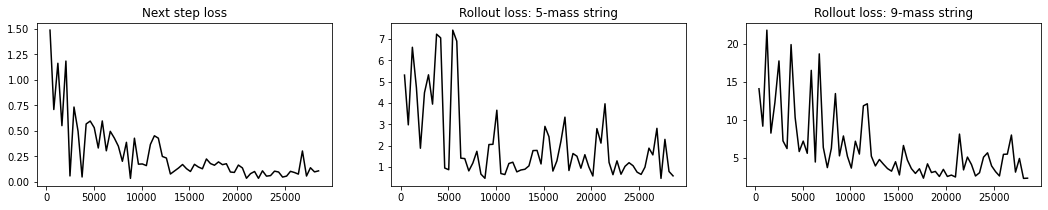

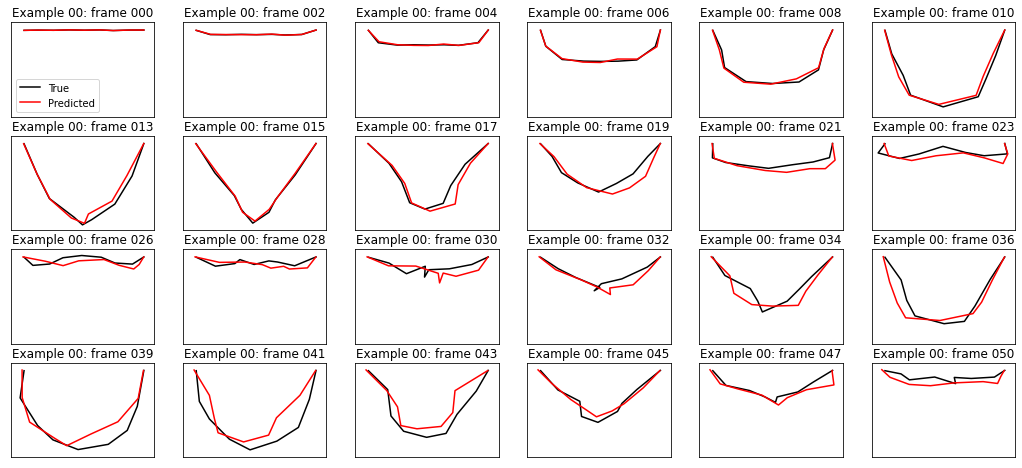

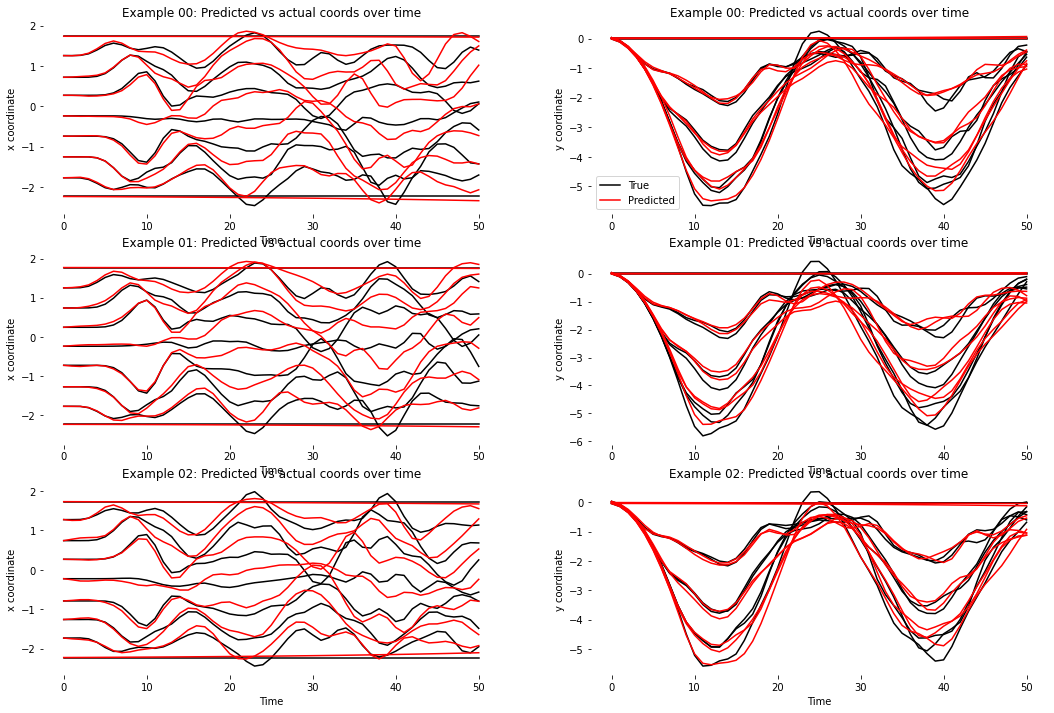

In [36]:
# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  return np.split(rollout_array[..., :2], batch_size, axis=1)


fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")
# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 5-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")

# Visualize trajectories.
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],
                                        batch_size_ge)
predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],
                                             batch_size_ge)
true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],
                                        batch_size_ge)
predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],
                                             batch_size_ge)

true_rollouts = true_rollouts_4
predicted_rollouts = predicted_rollouts_4
true_rollouts = true_rollouts_9
predicted_rollouts = predicted_rollouts_9

num_graphs = len(true_rollouts)
num_time_steps = true_rollouts[0].shape[0]

# Plot state sequences.
max_graphs_to_plot = 1
num_graphs_to_plot = min(num_graphs, max_graphs_to_plot)
num_steps_to_plot = 24
max_time_step = num_time_steps - 1
step_indices = np.floor(np.linspace(0, max_time_step,
                                    num_steps_to_plot)).astype(int).tolist()
w = 6
h = int(np.ceil(num_steps_to_plot / w))
fig = plt.figure(101, figsize=(18, 8))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  xys = np.hstack([predicted_rollout, true_rollout]).reshape([-1, 2])
  xs = xys[:, 0]
  ys = xys[:, 1]
  b = 0.05
  xmin = xs.min() - b * xs.ptp()
  xmax = xs.max() + b * xs.ptp()
  ymin = ys.min() - b * ys.ptp()
  ymax = ys.max() + b * ys.ptp()
  if i >= num_graphs_to_plot:
    break
  for j, step_index in enumerate(step_indices):
    iax = i * w + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(
        true_rollout[step_index, :, 0],
        true_rollout[step_index, :, 1],
        "k",
        label="True")
    ax.plot(
        predicted_rollout[step_index, :, 0],
        predicted_rollout[step_index, :, 1],
        "r",
        label="Predicted")
    ax.set_title("Example {:02d}: frame {:03d}".format(i, step_index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.legend(loc=3)

# Plot x and y trajectories over time.
max_graphs_to_plot = 3
num_graphs_to_plot = min(len(true_rollouts), max_graphs_to_plot)
w = 2
h = num_graphs_to_plot
fig = plt.figure(102, figsize=(18, 12))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  if i >= num_graphs_to_plot:
    break
  t = np.arange(num_time_steps)
  for j in range(2):
    coord_string = "x" if j == 0 else "y"
    iax = i * 2 + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(t, true_rollout[..., j], "k", label="True")
    ax.plot(t, predicted_rollout[..., j], "r", label="Predicted")
    ax.set_xlabel("Time")
    ax.set_ylabel("{} coordinate".format(coord_string))
    ax.set_title("Example {:02d}: Predicted vs actual coords over time".format(
        i))
    ax.set_frame_on(False)
    if i == 0 and j == 1:
      handles, labels = ax.get_legend_handles_labels()
      unique_labels = []
      unique_handles = []
      for i, (handle, label) in enumerate(zip(handles, labels)):  # pylint: disable=redefined-outer-name
        if label not in unique_labels:
          unique_labels.append(label)
          unique_handles.append(handle)
      ax.legend(unique_handles, unique_labels, loc=3)